### Topic A: Model Selection(Complexity Control)

In [15]:
import pandas as pd
#pd.read_csv() function reads the "haberman.data" file and creates a Pandas DataFrame object, which is assigned to the variable df. The header=None argument tells Pandas that there is no header row in the CSV file, and the names argument specifies the names of the columns in the DataFrame.
df = pd.read_csv('haberman.data', header=None,
names=["age_at_operation", "year_of_operation", "no_of_pos_aux_nodes", "survival_status"])
print(df)

     age_at_operation  year_of_operation  no_of_pos_aux_nodes  survival_status
0                  30                 64                    1                1
1                  30                 62                    3                1
2                  30                 65                    0                1
3                  31                 59                    2                1
4                  31                 65                    4                1
..                ...                ...                  ...              ...
301                75                 62                    1                1
302                76                 67                    0                1
303                77                 65                    3                1
304                78                 65                    1                2
305                83                 58                    2                2

[306 rows x 4 columns]


In [3]:
# as the year_of_operation is of no need so we have dropped that to reduce time complexity as we have to process data again and again 
df = df.drop("year_of_operation", axis=1)


#### Here we are normalizing our data 

In [4]:
#The min-max scaling method scales the data in each column to a range of 0 to 1. This is done by subtracting the minimum value in the column from each value in the column, then dividing by the range of the column (which is the difference between the maximum and minimum values).
def min_max_scaler(df: pd.DataFrame):
    for col, min, max in zip(df.columns, df.min(), df.max()):
        df[col] = df[col].map(lambda x: (x - min)/(max - min))
    return df
# now we have passed our data frame in the mnin_max_scaler function in order to get the normalized or scaled data
scaled_df = min_max_scaler(df)
scaled_df

,age_at_operation,no_of_pos_aux_nodes,survival_status
0,0.000000,0.019231,0.0
1,0.000000,0.057692,0.0
2,0.000000,0.000000,0.0
3,0.018868,0.038462,0.0
4,0.018868,0.076923,0.0
...,...,...,...
301,0.849057,0.019231,0.0
302,0.867925,0.000000,0.0
303,0.886792,0.057692,0.0
304,0.905660,0.019231,1.0


#### a.1 Implementation of KNN using euclidean

In [5]:
from scipy.spatial.distance import euclidean
import random

# here is the implementation of the KNN function which takes dataframe , K value and the new sample / datapoint for which you want to predict 
def KNN(dataframe: pd.DataFrame, K: int, new_datapoint: pd.Series) -> float:
    # here is the calculation for the K nearest data points of the given new sample then we have stored the data points in KNN_indices for further calculation
    # this function is taking K nearest points after sorting the data points by euclidean distance 
    KNN_indices = dataframe.reset_index(drop=True).drop("survival_status", axis=1).apply(lambda row: euclidean(row, new_datapoint), axis=1).sort_values()[:K].index
    
    # this freq is to store the frequency of 0 and 1 for the K points which are nearest to the new data point by "survival status" coloumn if the kth data point belongs to class 0 so we will increment freq[0]  otherwise we will increment   freq[1]
    freq = [0, 0]
    for i in KNN_indices:
        if dataframe.iloc[i]["survival_status"] == 0.0:
            freq[0] += 1
        else:
            freq[1] += 1

    # now if the freq[0]  is same as freq[1] for all KNN_indices i.e. the new data point can belong to class 0 or to class 1 so we will allot its class randomly
    if freq[0] == freq[1]:
        return random.choice(0.0, 1.0)
    #if freq[0] > freq[1] then we will assign 0 otherwise we will return 1
    if freq[0] > freq[1]:
        return 0.0
    else:
        return 1.0

#### a.2 Model Selection

##### LOO validation

In [6]:
# here is the implementation of Leave-One-Out which will tell us error rates for each and every K in b/w 1 to 99 with a diff of 2 i.e. we will take k as 1,3,5,7.....99
def LOO(dataframe):
    # here we had took unlabelled dataframe after dropping the class/label we will use it for prediction
    unlabelled_df = dataframe.drop("survival_status", axis=1)
    # this error[] is to append error for each and every K
    error = []

    # This outer look if to iterate for K values in range 1,3,5,7....99
    for K in range(1, min(100, dataframe.shape[0]), 2):
        # as we have took unlabelled dataframe so to take care of actual values we have stored the label of each row into actual_values and we also made a predicted_values list to store the predicted values 
        actual_values = [i for i in dataframe["survival_status"]]
        predicted_values = [None for _ in actual_values]
        # this inner look is to iterate over each and every row for each K value i.e. suppose K is 5 so for K = 5 it will iterate over all 300 rows  in order to find the predicted values 
        for i in range(dataframe.shape[0]):
            # here we are implementing the main conceps of LOO we are dropping the ith row and considering all other rows
            local_df = dataframe.drop(i, axis=0)
            # here we are predicting the label for the ith row  that we have dropped by considering all other rows as our training data 
            predicted_values[i] = KNN(local_df, K, unlabelled_df.iloc[i])
        
        # then we are calculating the mean square error or we can say error for our predeicted values by considering the actual values we are calculation this error for each and every K value so corresponding to each and every K there we are having a error and we are appending the K value with its MSE to the error[]
        MSE = sum([abs(a - p) for a, p in zip(actual_values, predicted_values)])/local_df.shape[0]
        error.append([K, MSE])

    # then we have returned the error list by converting it to a pandas dataframe 
    return pd.DataFrame(error, columns=["K", "error"])

# then we have performed above LOO process on our scaled dataframe and we got dataframe with K value and its corresponding error    
cross_val_err = LOO(scaled_df)

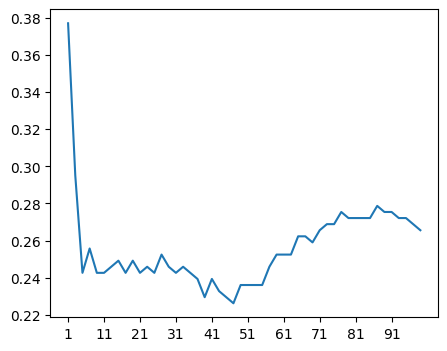

In [7]:
# here we are plotting the errors corresponding to the K values which we stored in cross_val_error data frame
import matplotlib.pyplot as plt
plt.figure(figsize = (5,4))
plt.xticks(list(range(1, 100, 10)))
# plt.bar(cross_val_err["K"], cross_val_err["error"])
plt.plot(cross_val_err["K"], cross_val_err["error"])


##### Now we will find the optimal K value i.e. the K value for which the error is minimum

In [8]:
# so here in first line of code we found the row in cross_val_error df having the minimum error using idxmin() bcoz in each row there is K and its corresponding error so if we fount the index of the row with minimum error so we can also find the K value for that by accessing coloumn "K" 
optimal_K_row = cross_val_err.iloc[cross_val_err["error"].idxmin()]
optimal_K = int(optimal_K_row["K"])
optimal_err = optimal_K_row["error"]
# Now lets print out the optimal k value and the minimum error corresponding to that
print("Optimal value of K is :", optimal_K)
print("Error corresponding to the optimal K value is :", optimal_err)


Optimal value of K is : 47
Error corresponding to the optimal K value is : 0.2262295081967213


#### Plotting Decision Boundary 
-> For that we are scattered the points all over the 2D grid  to visualize the decision boundary

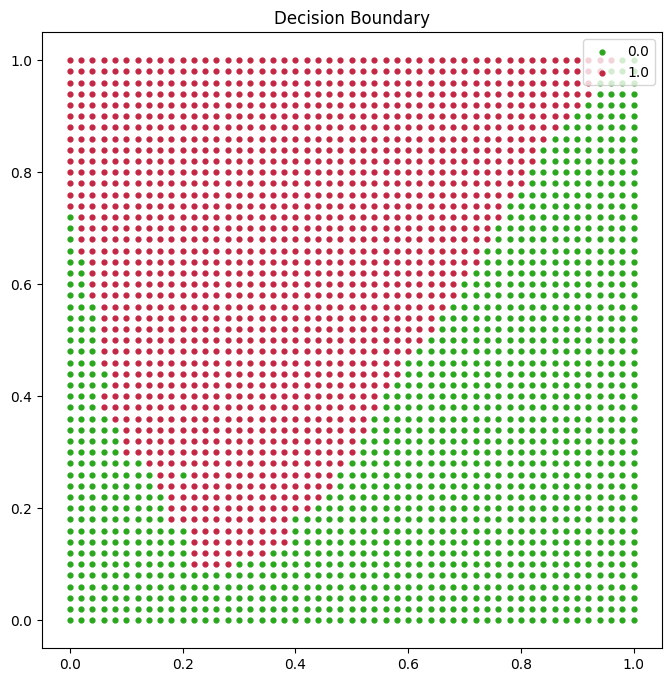

In [9]:
# here we are setting the dimension of the 
points = []
dim = 50
# here we are iterating over the dimension of the grid in order to apped the coordinated of the data points to the points list with their corresponding predicted label using KNN and optimal K
for i in range(dim+1):
    for j in range(dim+1):
        points.append([i/dim, j/dim, KNN(scaled_df, optimal_K, [i/30, j/30])])
# here we are converting the list of points to the pandas dataframe with their feature or attribute names 
points = pd.DataFrame(points, columns=['x', 'y', 'class'])
# now we are grouping the data points according to their predicted labels the groups with class i.e. we have created two groups correspondint to label 0 and label 1
grouped_points = [i for _, i in points.groupby("class", sort=False)]

# NOw we have plotted the grouped points with green color as class 0 and red as class 1
plt.rcParams["figure.figsize"] = (8, 8)
for pts, color in zip([i for i in grouped_points], ["#2AA71D", "#C32744"]):
    # getting the class of each datapoint & then plotting it on the grid 
    cls = pts.iloc[0]["class"]
    plt.scatter(pts["x"], pts["y"], c=color, s=12.0, label=cls)
plt.title("Decision Boundary")
plt.legend(loc='upper right')
plt.show()


#### a.3 Predicting accuracy of learning method using 5 fold cross validation

In [10]:
# here we are creating 5 folds or we breaked data into 5 parts having around equal no of rows or samples 
sorted_df = scaled_df.sort_values("age_at_operation")
folds = [pd.DataFrame(sorted_df.iloc[i::5]).reset_index(drop=True) for i in range(5)]
folds

[    age_at_operation  no_of_pos_aux_nodes  survival_status
 0           0.000000             0.019231              0.0
 1           0.056604             0.192308              0.0
 2           0.075472             0.019231              0.0
 3           0.094340             0.000000              0.0
 4           0.132075             0.000000              0.0
 ..               ...                  ...              ...
 57          0.754717             0.000000              1.0
 58          0.754717             0.153846              0.0
 59          0.792453             0.000000              0.0
 60          0.830189             0.000000              0.0
 61          1.000000             0.038462              1.0
 
 [62 rows x 3 columns],
     age_at_operation  no_of_pos_aux_nodes  survival_status
 0           0.000000             0.057692              0.0
 1           0.056604             0.000000              0.0
 2           0.075472             0.192308              0.0
 3           0

##### Here we are finding the optimal k for each fold using LOO Validation

In [11]:
# here we have found the error list for each fold using the LOO()
cross_val_errs = [LOO(i) for i in folds]
print(cross_val_errs)
# now we will find the the rows in each fold with least error in order to find the optimal k for each fold
optimal_K_rows = [i.iloc[i["error"].idxmin()] for i in cross_val_errs]
# using optimal_K_rows here we are finding the optimal K values corresponding to each fold
optimal_Ks = [int(i["K"]) for i in optimal_K_rows]
# here we are taking the minimum errors corresponding to the optimal K's for each fold
loo_val_errs = [i["error"] for i in optimal_K_rows]


[     K     error
0    1  0.327869
1    3  0.327869
2    5  0.295082
3    7  0.295082
4    9  0.262295
5   11  0.245902
6   13  0.278689
7   15  0.278689
8   17  0.311475
9   19  0.295082
10  21  0.295082
11  23  0.295082
12  25  0.278689
13  27  0.278689
14  29  0.278689
15  31  0.278689
16  33  0.278689
17  35  0.278689
18  37  0.278689
19  39  0.278689
20  41  0.278689
21  43  0.278689
22  45  0.278689
23  47  0.278689
24  49  0.278689
25  51  0.278689
26  53  0.278689
27  55  0.278689
28  57  0.278689
29  59  0.278689
30  61  0.278689,      K     error
0    1  0.400000
1    3  0.383333
2    5  0.416667
3    7  0.416667
4    9  0.333333
5   11  0.300000
6   13  0.350000
7   15  0.316667
8   17  0.316667
9   19  0.333333
10  21  0.350000
11  23  0.350000
12  25  0.333333
13  27  0.333333
14  29  0.333333
15  31  0.333333
16  33  0.333333
17  35  0.333333
18  37  0.333333
19  39  0.333333
20  41  0.333333
21  43  0.333333
22  45  0.333333
23  47  0.333333
24  49  0.333333
25  51  0.33

Calculating test error

In [12]:
# Here we will find the errors corresponding to the test sets
def test(train: pd.DataFrame, test: list, K: int):
    # here we are concatinating all the folds except the ith fold so the test set comprises of 4 folds
    test = pd.concat(test, ignore_index=True)
    # In order to find the predicted values of the test set we dropped the label
    test_df = test.drop("survival_status", axis=1)
    # here we are taking the ith fold as training set  which we are not considering in test set 
    train_df = train
    # keeping track of actual values in order to find error in prediction
    actual_values = [i for i in test["survival_status"]]
    # created a list of predicted values for the test set using KNN algorithm
    predicted_values = [KNN(train_df, K, i) for _, i in test_df.iterrows()]
    # caluated the MSE corresponding to actual and predicted values
    MSE = sum([abs(a - p) for a, p in zip(actual_values, predicted_values)])/test_df.shape[0]
    return MSE

# here we have stored estimated errors  for each fold using its corresponding optimal K value
est_test_errs = [test(folds[i], [folds[j] for j in range(5) if j != i], optimal_Ks[i]) for i in range(5)]

print(est_test_errs)


[0.2459016393442623, 0.23673469387755103, 0.2612244897959184, 0.32653061224489793, 0.27346938775510204]


In [13]:
# here we are printing the ith fold with its optimal k value and Loo validation error and with estimated test error
pd.DataFrame({
    "fold_no": [1, 2, 3, 4, 5],
    "optimal k value for the fold": optimal_Ks,
    "loo validation error for the fold": loo_val_errs,
    "estimated test error for the fold": est_test_errs
})

,fold_no,optimal k value for the fold,loo validation error for the fold,estimated test error for the fold
0,1,11,0.245902,0.245902
1,2,11,0.300000,0.236735
2,3,5,0.150000,0.261224
3,4,1,0.283333,0.326531
4,5,9,0.233333,0.273469


In [14]:
avg_test_err = sum(est_test_errs)/5
avg_loo_val_err = sum(loo_val_errs)/5
print("Average LOO Validation:", avg_loo_val_err)
print("Average test error:", avg_test_err)
print("Optimal K  error:", optimal_err)

Average LOO Validation: 0.2425136612021858
Average test error: 0.2687721646035463
Optimal K  error: 0.2262295081967213


<br>
End of Topic-A